In [1]:
!pip install "numpy<2" ultralytics roboflow supervision opencv-python opencv-python-headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 97.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: nu

In [1]:
import torch
from ultralytics import YOLO
import os
import shutil
import yaml
from pathlib import Path
from google.colab import drive, files
import matplotlib.pyplot as plt
import cv2
import numpy as np

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
GPU Memory: 14.7 GB


In [2]:
drive.mount('/content/drive')

DATASET_PATH = "/content/cat_dataset"
DRIVE_DATASET_PATH = "/content/drive/MyDrive/ML_Files/cat_body_parts_dataset"

os.makedirs(f"{DATASET_PATH}/images/train", exist_ok=True)
os.makedirs(f"{DATASET_PATH}/images/val", exist_ok=True)
os.makedirs(f"{DATASET_PATH}/images/test", exist_ok=True)
os.makedirs(f"{DATASET_PATH}/labels/train", exist_ok=True)
os.makedirs(f"{DATASET_PATH}/labels/val", exist_ok=True)
os.makedirs(f"{DATASET_PATH}/labels/test", exist_ok=True)

print("Directory structure created!")

Mounted at /content/drive
Directory structure created!


In [3]:
if os.path.exists(f"{DRIVE_DATASET_PATH}/images"):
    shutil.copytree(f"{DRIVE_DATASET_PATH}/images", f"{DATASET_PATH}/images", dirs_exist_ok=True)
    print("Images copied from Drive")

if os.path.exists(f"{DRIVE_DATASET_PATH}/labels"):
    shutil.copytree(f"{DRIVE_DATASET_PATH}/labels", f"{DATASET_PATH}/labels", dirs_exist_ok=True)
    print("Labels copied from Drive")

for split in ['train', 'val', 'test']:
    img_count = len(os.listdir(f"{DATASET_PATH}/images/{split}"))
    label_count = len(os.listdir(f"{DATASET_PATH}/labels/{split}"))
    print(f"{split}: {img_count} images, {label_count} labels")

Images copied from Drive
Labels copied from Drive
train: 296 images, 296 labels
val: 76 images, 76 labels
test: 74 images, 74 labels


In [4]:
dataset_config = {
    'path': '/content/cat_dataset',
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'nc': 3,
    'names': {
        0: 'eye',
        1: 'mouth',
        2: 'tail'
    }
}


yaml_path = '/content/cat_dataset.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(dataset_config, f, default_flow_style=False)

print(f"✅ YAML file created at: {yaml_path}")

with open(yaml_path, 'r') as f:
    print("\n📄 Generated YAML content:")
    print(f.read())

✅ YAML file created at: /content/cat_dataset.yaml

📄 Generated YAML content:
names:
  0: eye
  1: mouth
  2: tail
nc: 3
path: /content/cat_dataset
test: images/test
train: images/train
val: images/val



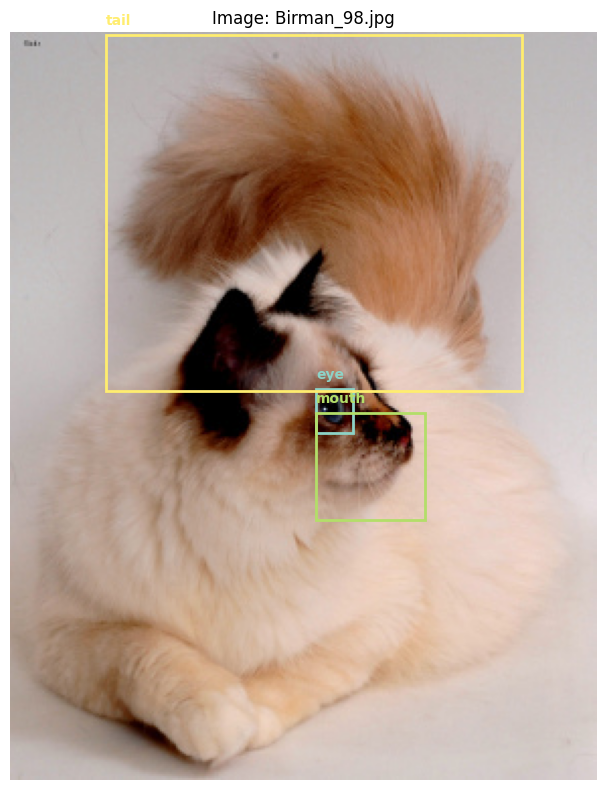

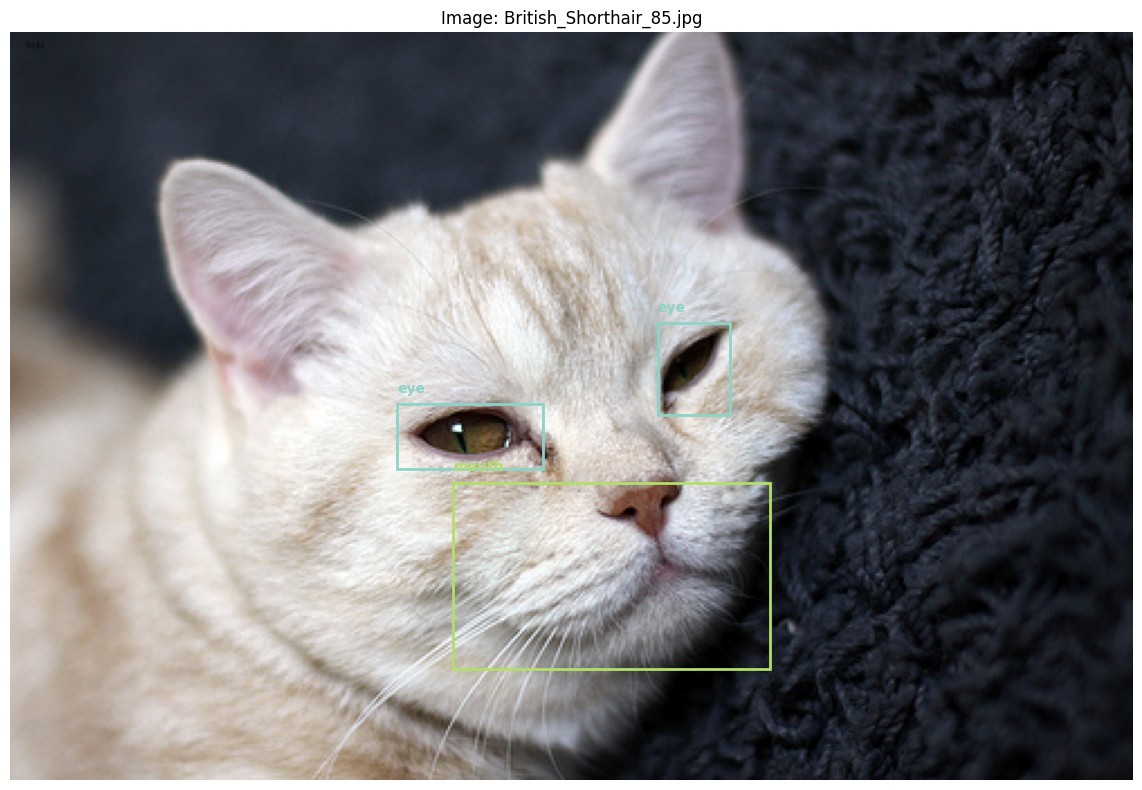

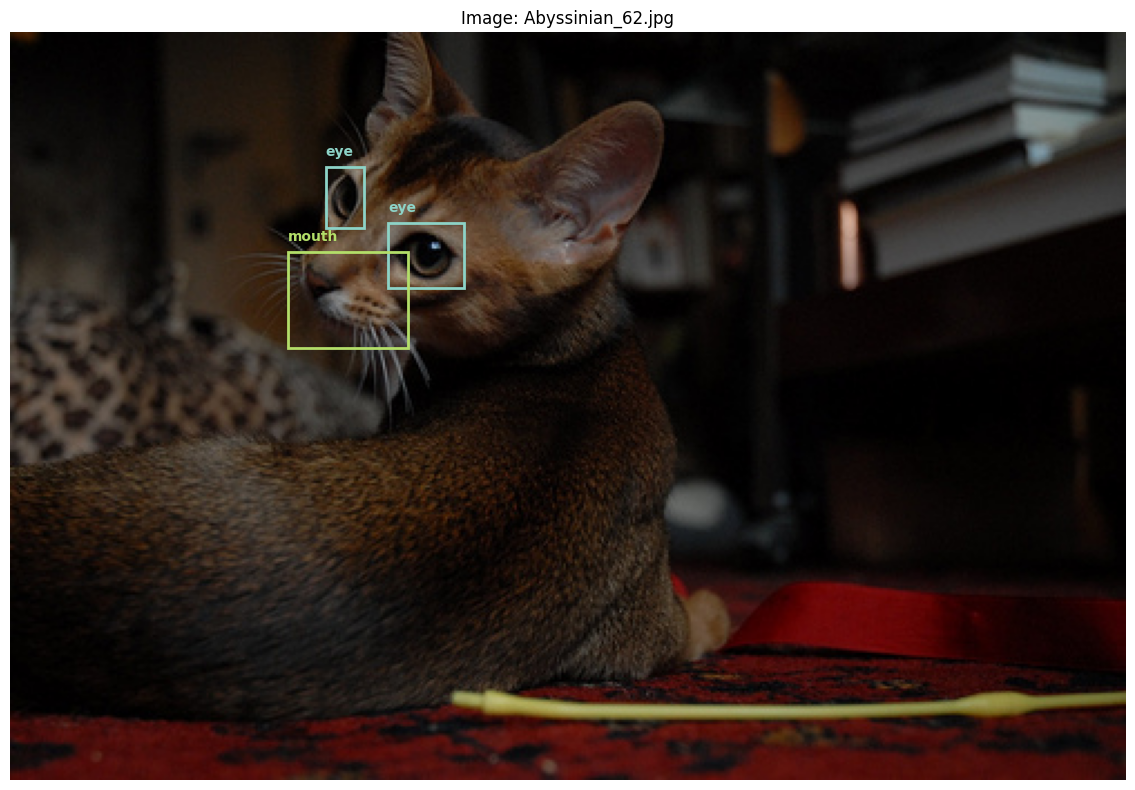

In [5]:
import matplotlib.patches as patches
from PIL import Image

def visualize_annotations(image_path, label_path, class_names):
    """Visualize an image with its annotations"""

    img = Image.open(image_path)
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)


    with open(label_path, 'r') as f:
        annotations = f.readlines()

    # Draw bounding boxes
    img_width, img_height = img.size
    colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))

    for ann in annotations:
        parts = ann.strip().split()
        if len(parts) == 5:
            class_id, x_center, y_center, width, height = map(float, parts)

            # Convert normalized coordinates to pixel coordinates
            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height


            x_min = x_center - width/2
            y_min = y_center - height/2

            rect = patches.Rectangle(
                (x_min, y_min), width, height,
                linewidth=2, edgecolor=colors[int(class_id)],
                facecolor='none'
            )
            ax.add_patch(rect)

            ax.text(x_min, y_min-5, class_names[int(class_id)],
                   color=colors[int(class_id)], fontsize=10, weight='bold')

    ax.set_title(f"Image: {os.path.basename(image_path)}")
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Some visualizations
train_images = os.listdir(f"{DATASET_PATH}/images/train")[:3]
for img_name in train_images:
    img_path = f"{DATASET_PATH}/images/train/{img_name}"
    label_path = f"{DATASET_PATH}/labels/train/{img_name.rsplit('.', 1)[0]}.txt"

    if os.path.exists(label_path):
        visualize_annotations(img_path, label_path, dataset_config['names'])

In [6]:
def train_cat_model():
    print(f"Using device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

    # YOLOv8 Pretrained Model
    model = YOLO('yolov8s.pt')

    #
    results = model.train(
        data='/content/cat_dataset.yaml',
        epochs=75,
        imgsz=640,
        batch=8,
        device=0 if torch.cuda.is_available() else 'cpu',
        patience=10,
        save=True,
        project='/content/cat_training',
        name='yolov8s_cat_parts',
        exist_ok=True,
        val=True,
        plots=True
    )

    return model, results

if os.path.exists('/content/cat_dataset.yaml'):
    print("✅ Dataset config found")
    if os.path.exists('/content/cat_dataset'):
        print("✅ Dataset folder found")
        print("Starting training...")
        trained_model, training_results = train_cat_model()
        print("Training completed!")
    else:
        print("❌ Dataset folder not found at /content/cat_dataset")
else:
    print("❌ Dataset config not found at /content/cat_dataset.yaml")

✅ Dataset config found
✅ Dataset folder found
Starting training...
Using device: cuda
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/cat_dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=75, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8s_cat_parts, nbs=64, nms=False, opset=None, optimize=F


results.png:


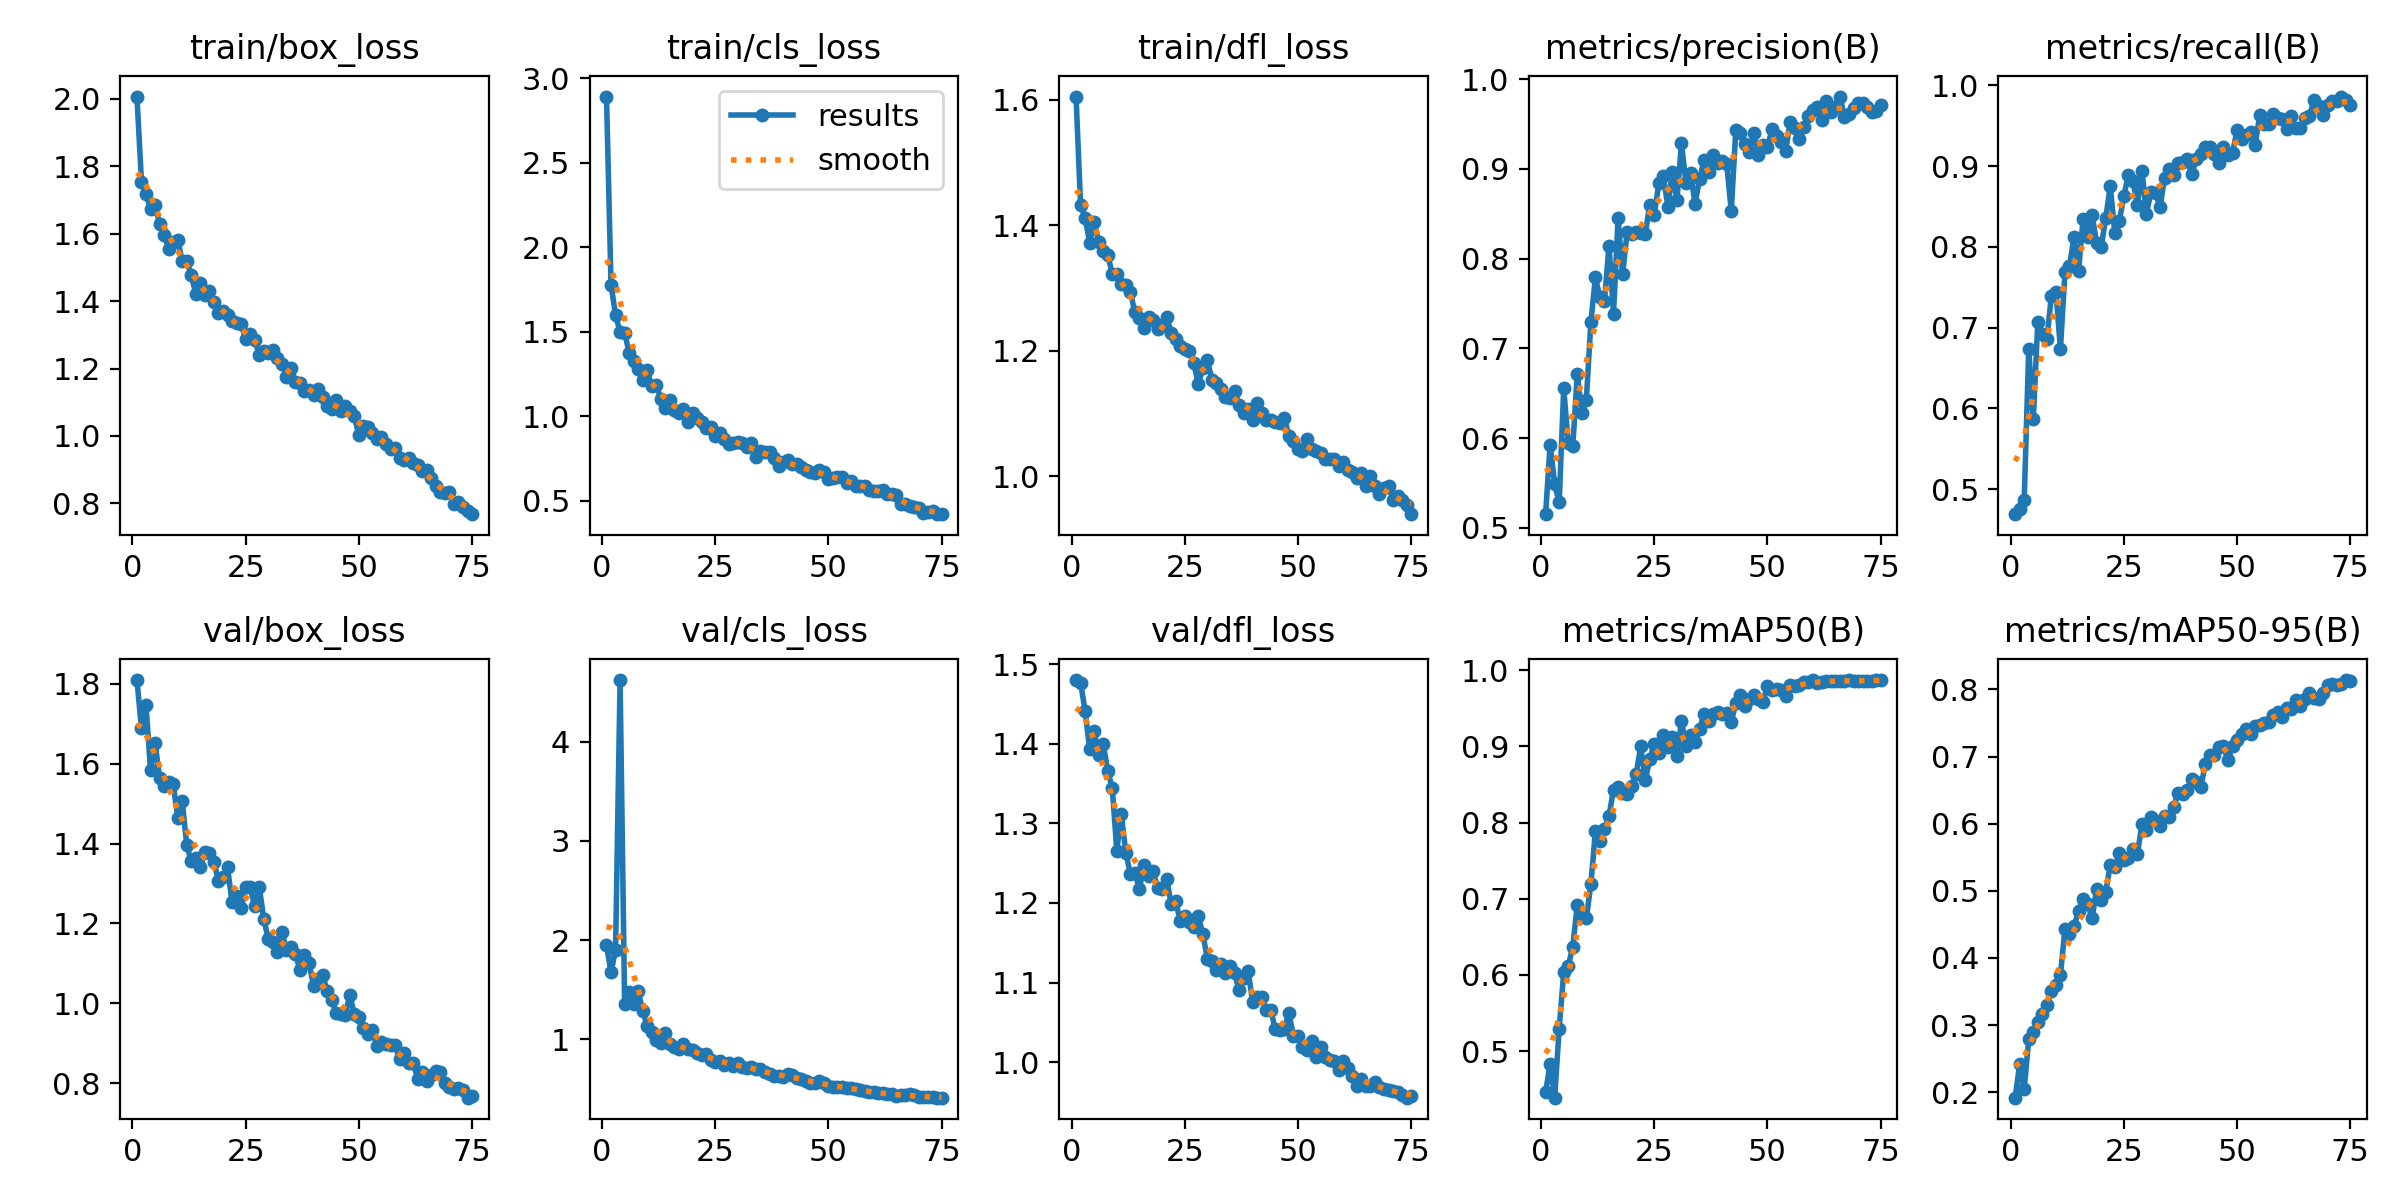


confusion_matrix.png:


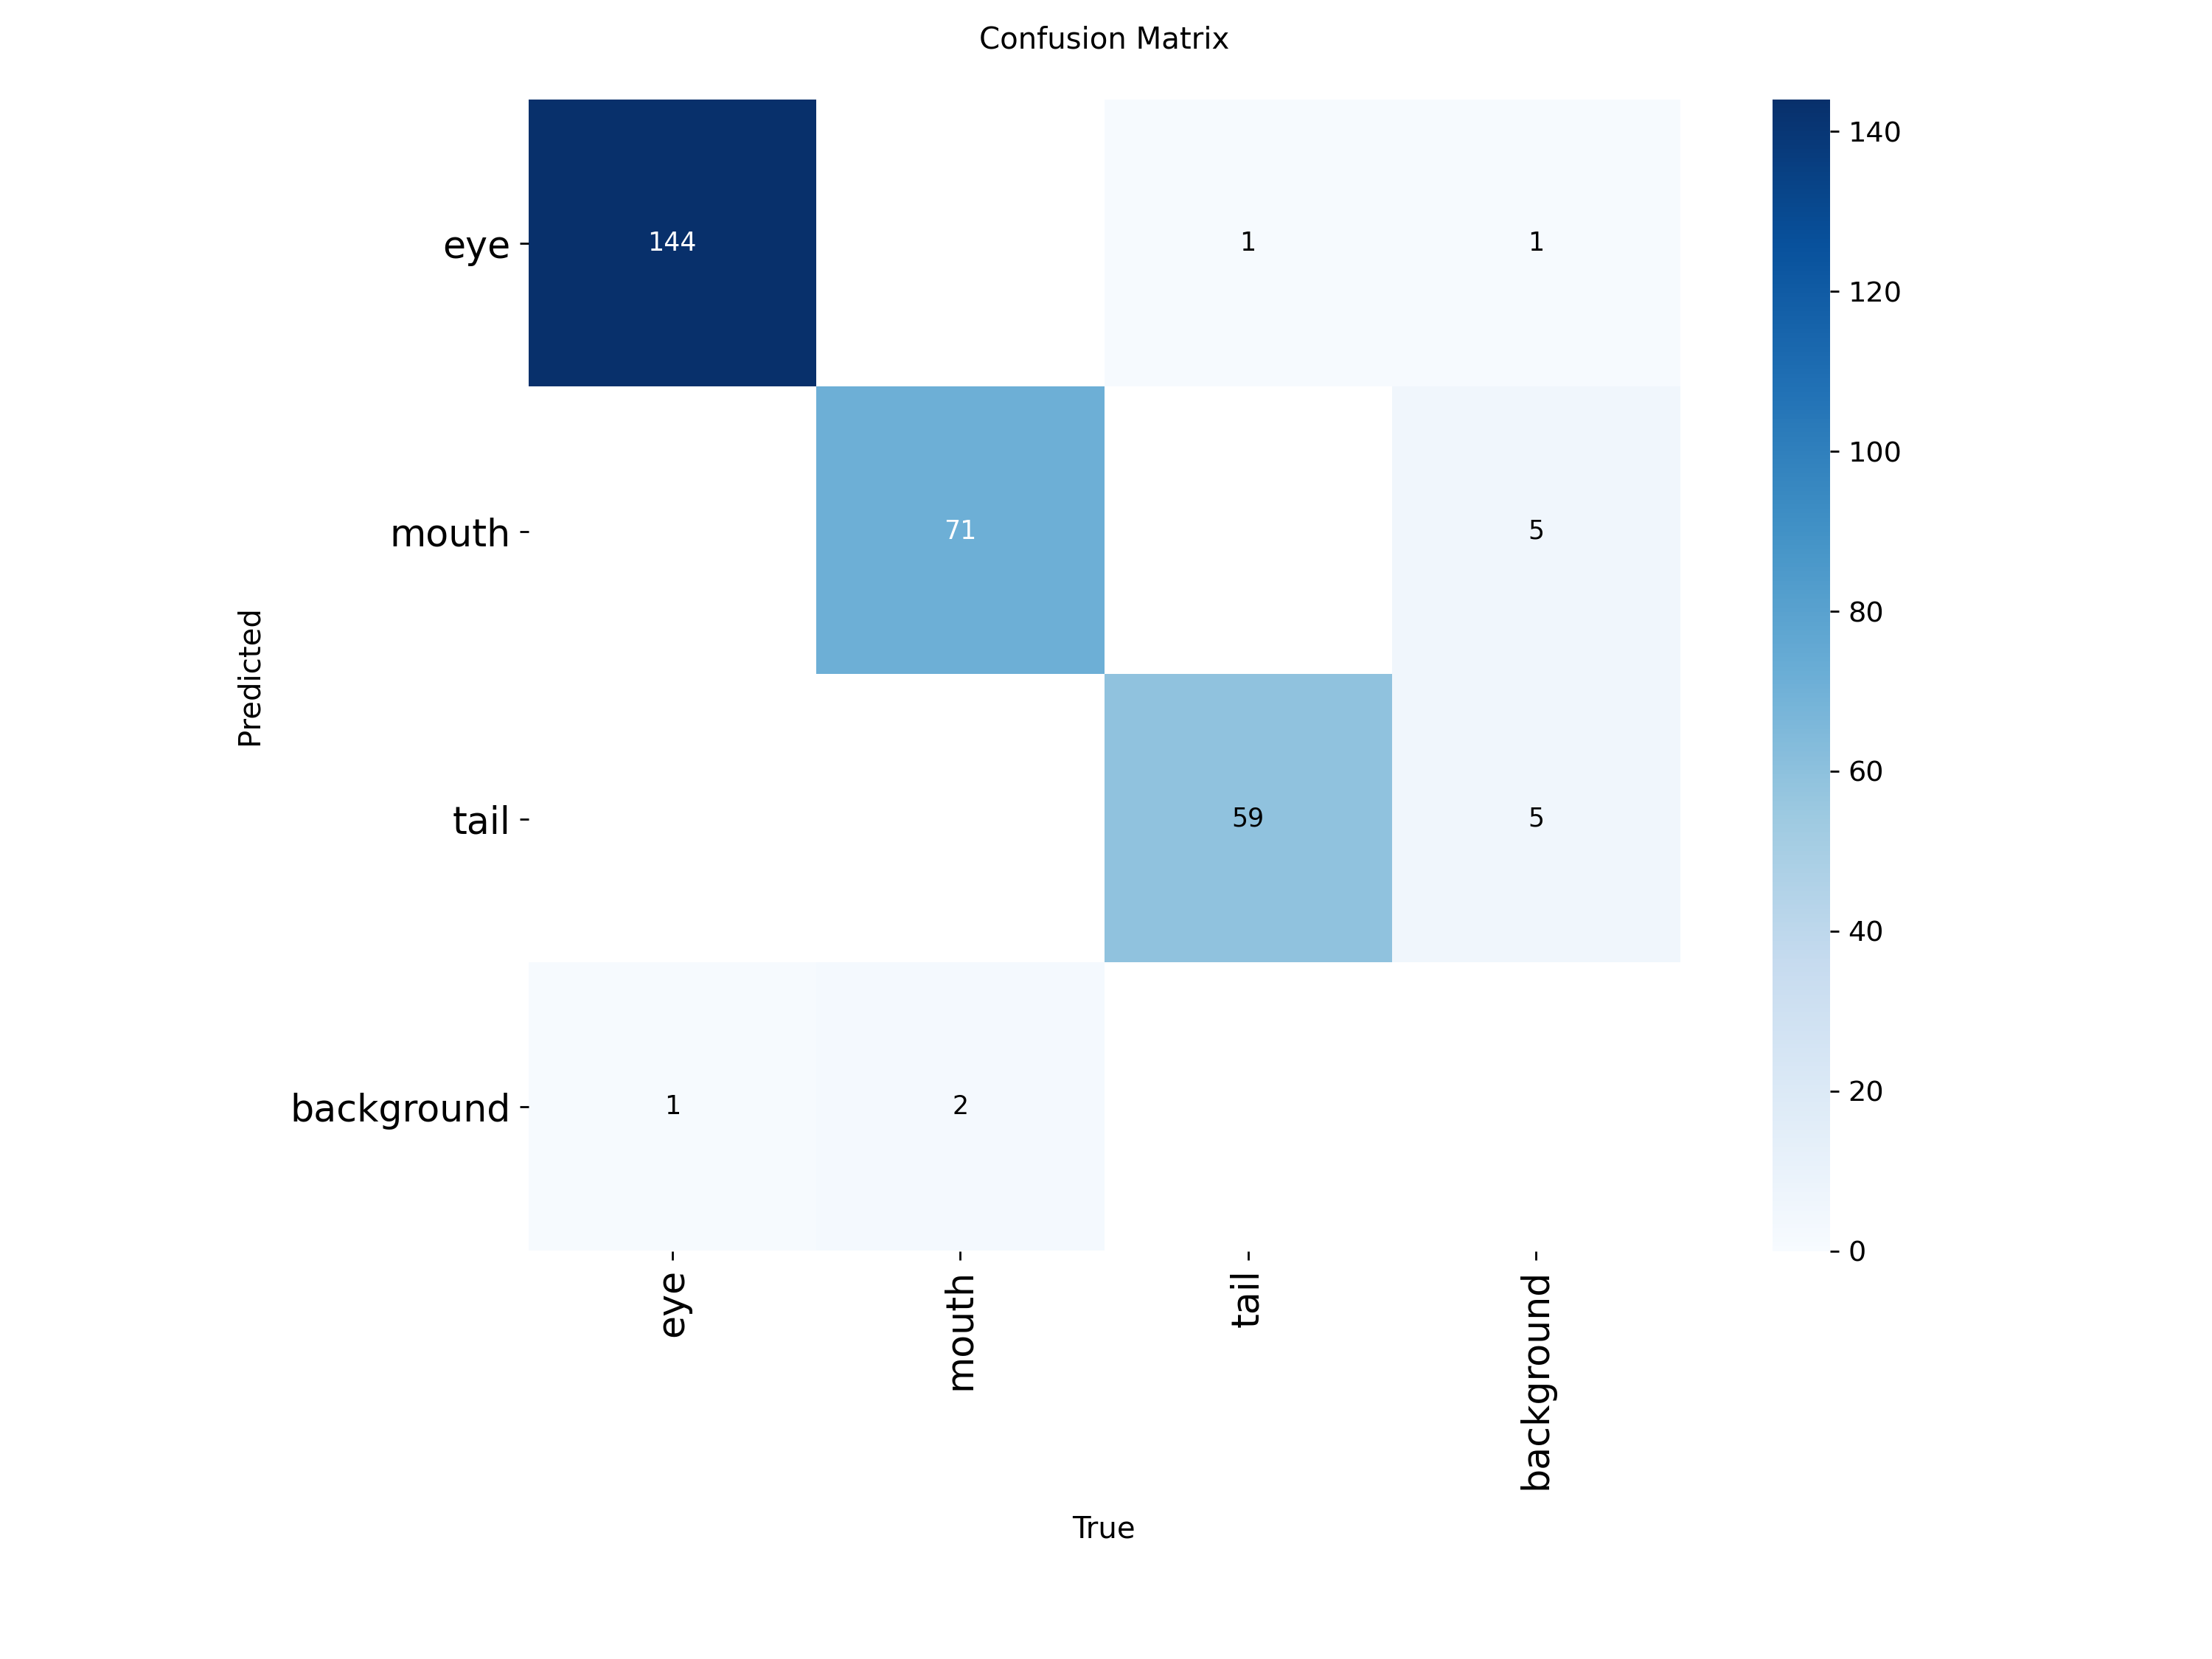

In [7]:
from IPython.display import Image as IPImage, display

results_path = "/content/cat_training/yolov8s_cat_parts"

plot_files = [
    'results.png',
    'confusion_matrix.png',
    'F1_curve.png',
    'P_curve.png',
    'R_curve.png',
    'PR_curve.png'
]

for plot_file in plot_files:
    plot_path = f"{results_path}/{plot_file}"
    if os.path.exists(plot_path):
        print(f"\n{plot_file}:")
        display(IPImage(plot_path))

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 931.8±463.6 MB/s, size: 66.4 KB)
val: Scanning /content/cat_dataset/labels/val.cache... 76 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 76/76 158.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 2.1it/s 2.4s
                   all         76        278      0.964      0.982      0.987      0.812
                   eye         75        145      0.986      0.985      0.995      0.792
                 mouth         73         73      0.946      0.961      0.973      0.769
                  tail         56         60      0.961          1      0.993      0.875
Speed: 4.6ms preprocess, 11.3ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to /content/runs/detect/val
Validation Res

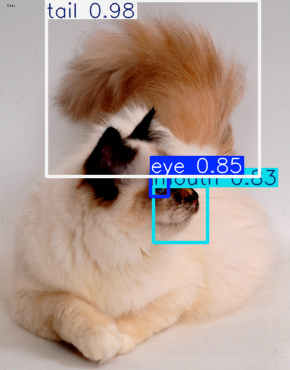


Detections in Birman_98.jpg:
  tail: 0.982
  eye: 0.854
  mouth: 0.832

image 1/1 /content/cat_dataset/images/test/Bengal_171.jpg: 480x640 2 eyes, 1 mouth, 82.2ms
Speed: 5.7ms preprocess, 82.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


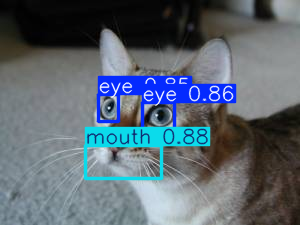


Detections in Bengal_171.jpg:
  mouth: 0.878
  eye: 0.862
  eye: 0.845

image 1/1 /content/cat_dataset/images/test/Siamese_44.jpg: 640x480 2 eyes, 1 mouth, 1 tail, 71.3ms
Speed: 4.5ms preprocess, 71.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


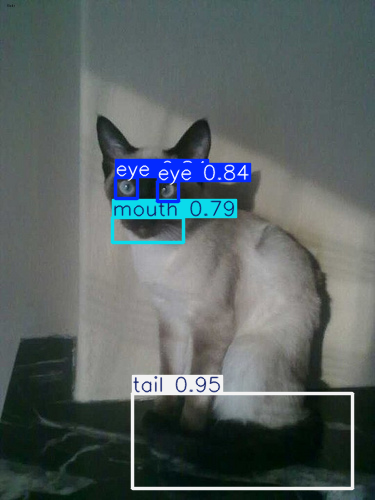


Detections in Siamese_44.jpg:
  tail: 0.950
  eye: 0.840
  eye: 0.839
  mouth: 0.786


In [8]:
# Load the best trained model
best_model = YOLO(f'{results_path}/weights/best.pt')

# Validate the model
metrics = best_model.val()

print(f"Validation Results:")
print(f"mAP50: {metrics.box.map50:.4f}")
print(f"mAP50-95: {metrics.box.map:.4f}")
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall: {metrics.box.mr:.4f}")

# Test on individual images
test_images = os.listdir(f"{DATASET_PATH}/images/test")[:3]

for img_name in test_images:
    img_path = f"{DATASET_PATH}/images/test/{img_name}"


    results = best_model(img_path)

    results[0].show()

    boxes = results[0].boxes
    if boxes is not None:
        print(f"\nDetections in {img_name}:")
        for i, box in enumerate(boxes):
            class_id = int(box.cls[0])
            confidence = float(box.conf[0])
            class_name = dataset_config['names'][class_id]
            print(f"  {class_name}: {confidence:.3f}")

In [9]:
drive_save_path = "/content/drive/MyDrive/YOLOv8_Cat_Model"
os.makedirs(drive_save_path, exist_ok=True)

shutil.copy(f'{results_path}/weights/best.pt', f'{drive_save_path}/best_cat_model.pt')
shutil.copy(f'{results_path}/weights/last.pt', f'{drive_save_path}/last_cat_model.pt')

shutil.copy('/content/cat_dataset.yaml', f'{drive_save_path}/cat_dataset.yaml')

if os.path.exists(f'{results_path}/results.csv'):
    shutil.copy(f'{results_path}/results.csv', f'{drive_save_path}/training_results.csv')

print("Model and results saved to Google Drive!")

Model and results saved to Google Drive!



image 1/1 /content/cat_dataset/images/test/Birman_138.jpg: 640x448 2 eyes, 1 mouth, 48.2ms
Speed: 2.0ms preprocess, 48.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


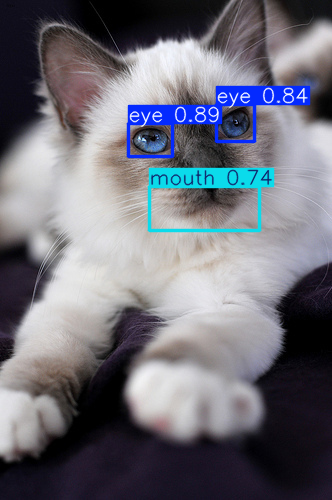

Found 3 detections:
  1. eye: 0.891
  2. eye: 0.836
  3. mouth: 0.736


In [10]:
def test_inference(model_path, image_path, conf_threshold=0.5):
    """Test inference on a single image"""
    model = YOLO(model_path)

    results = model(image_path, conf=conf_threshold)

    results[0].show()

    boxes = results[0].boxes
    if boxes is not None:
        print(f"Found {len(boxes)} detections:")
        for i, box in enumerate(boxes):
            class_id = int(box.cls[0])
            confidence = float(box.conf[0])
            class_name = dataset_config['names'][class_id]
            print(f"  {i+1}. {class_name}: {confidence:.3f}")
    else:
        print("No detections found")

    return results

test_image_path = f"{DATASET_PATH}/images/test/{os.listdir(f'{DATASET_PATH}/images/test')[6]}"
test_results = test_inference(f'{results_path}/weights/best.pt', test_image_path)

In [11]:
model = YOLO(f'{results_path}/weights/best.pt')

# Export to ONNX
onnx_path = model.export(format='onnx', imgsz=640, optimize=True)
print(f"ONNX model exported to: {onnx_path}")

if onnx_path:
    shutil.copy(onnx_path, f'{drive_save_path}/cat_model.onnx')
    print("ONNX model saved to Drive!")

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs

PyTorch: starting from '/content/cat_training/yolov8s_cat_parts/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (21.5 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<=1.19.1', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 14 packages in 235ms
Prepared 6 packages in 6.78s
Installed 6 packages in 315ms
 + colorama==0.4.6
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnx==1.19.1
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.78

requirements: AutoUpdate success ✅ 8.0s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect

